In [1]:
import mytorch.nn as nn
import mytorch.nn.functional as F
from mytorch.optim import SGD
from mytorch.utils import DataLoader

import torch
import matplotlib.pyplot as plt
import random


In [2]:
# Load makemore data
words = open('../makemore_jax/names.txt', 'r').read().splitlines()
print(f'Number of names: {len(words)}')
print(
    f'Median name length: {torch.median(torch.tensor(list(len(w) for w in words))).item()}')
print(f'Max name length: {max(len(w) for w in words)}')
print(f'Example names: {words[:8]}')

# build the vocapbulary of charactors mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


Number of names: 32033
Median name length: 6
Max name length: 15
Example names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [3]:
random.seed(42)
random.shuffle(words)
block_size = 3


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [4]:
torch.manual_seed(42)
n_embd = 10
n_hidden = 200
batch_size = 32

class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential([
            nn.Embedding(vocab_size, n_embd),
            nn.Flatten(),
            nn.Linear(n_embd*block_size, n_hidden,    
                   bias=False),nn.BatchNorm1d(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, vocab_size),
        ])

        parameters = self.model.parameters()
        for p in parameters:
            p.requires_grad = True

    def forward(self, x):
        return self(x)


model = MyModel()
#print(model.model)

data = DataLoader(Xtr, Ytr, batch_size=batch_size)


In [5]:
max_epochs = 40


class MyTrainer(nn.Trainer):

    def training_step(self, batch):
        # Forward pass
        features, targets = batch
        logits = self.model(features)
        loss = F.cross_entropy(logits, targets)
        return loss

    def configure_optimizers(self):
        optimizer = SGD(self.model.parameters(), lr=0.1)
        return optimizer

    def predict(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        return ix


trainer = MyTrainer(model=model, max_epochs=max_epochs)


Trainer initialized with the model:
Sequential(
  (0): Embedding(num_embeddings=27, embedding_dim=10), Total parameters: 270, 
  (1): Flatten(), Total parameters: 0, 
  (2): Linear(in_features=30, out_features=200, bias=False), Total parameters: 6000, 
  (3): Batchnorm1D(num_features=200), Total parameters: 400, 
  (4): Tanh(), Total parameters: 0, 
  (5): Linear(in_features=200, out_features=27, bias=True), Total parameters: 5427, 
)
Total parameters: 12097


In [6]:
trainer.fit(data)

Epoch   0/40: loss = 3.829589
Epoch   1/40: loss = 2.403496
Epoch   2/40: loss = 2.297980
Epoch   3/40: loss = 2.264791
Epoch   4/40: loss = 2.243546
Epoch   5/40: loss = 2.228312
Epoch   6/40: loss = 2.216768
Epoch   7/40: loss = 2.207742
Epoch   8/40: loss = 2.200488
Epoch   9/40: loss = 2.194517
Epoch  10/40: loss = 2.189502
Epoch  11/40: loss = 2.185218
Epoch  12/40: loss = 2.181500
Epoch  13/40: loss = 2.178224
Epoch  14/40: loss = 2.175298
Epoch  15/40: loss = 2.172653
Epoch  16/40: loss = 2.170246
Epoch  17/40: loss = 2.168045
Epoch  18/40: loss = 2.166027
Epoch  19/40: loss = 2.164170
Epoch  20/40: loss = 2.094188
Epoch  21/40: loss = 2.088578
Epoch  22/40: loss = 2.087218
Epoch  23/40: loss = 2.086286
Epoch  24/40: loss = 2.085546
Epoch  25/40: loss = 2.084918
Epoch  26/40: loss = 2.084364
Epoch  27/40: loss = 2.083863
Epoch  28/40: loss = 2.083403
Epoch  29/40: loss = 2.082974
Epoch  30/40: loss = 2.082571
Epoch  31/40: loss = 2.082189
Epoch  32/40: loss = 2.081826
Epoch  33/

In [7]:
@torch.no_grad()
def split_loss(split):
    batch = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    loss = trainer.validation_step(batch)
    print(split, loss.item())


split_loss('train')
split_loss('val')


train 2.0660884380340576
val 2.1118886470794678


In [12]:
with torch.no_grad():
    for _ in range(20):

        out = []
        context = [0] * block_size
        while True:
            x = torch.tensor([context])
            
            # Use either
            #logits = trainer.model(x)
            #probs = F.softmax(logits, dim=1)
            #ix = torch.multinomial(probs, num_samples=1).item()

            # Or
            ix =  trainer.predict(x)
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itos[i] for i in out))


zya.
dashaye.
monce.
usuai.
rayciel.
pon.
aud.
ahnalintree.
any.
rheen.
adelynn.
gran.
solvi.
rosel.
sarnelah.
dezya.
samyra.
ruham.
jaeluette.
lam.


In [13]:
max_steps = 3000
batch_size = 64
lossi = []
ud = []
optim = SGD(parameters, lr=0.1)


class Trainer:
    def __init__(self, model, data, optim):
        self.model = model
        self.data = data
        self.optim = optim


for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Zero Grad and Backward pass
    optim.zero_grad()
    loss.backward()

    # Update
    optim.lr = 0.1 if i < max_steps/2 else 0.01

    # for p in parameters:
    #    p.data += -lr * p.grad
    optim.step()

    LOG_N = 1000
    lossi.append(loss.item())
    if i % LOG_N == 0:
        mloss = torch.tensor(lossi)[-LOG_N:].mean()
        print(f'{i:7d}/{max_steps:d}: {mloss.item():4f}, {optim.lr}')

    with torch.no_grad():
        ud.append([(optim.lr*p.grad.std()/p.data.std()).log10().item()
                  for p in parameters])


      0/3000: 3.747302, 0.1
   1000/3000: 2.523225, 0.1
   2000/3000: 2.363503, 0.01


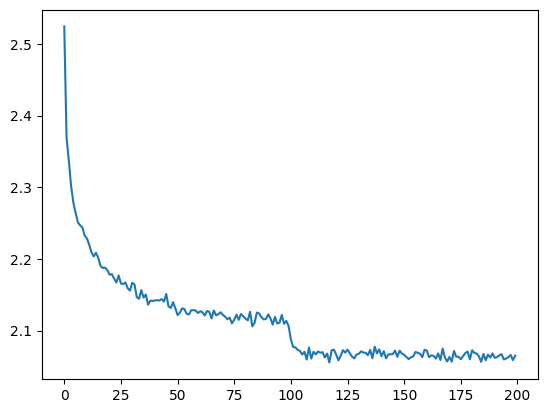

In [8]:
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1, keepdim=True))


In [81]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


for layer in model.layers:
    layer.training = False
split_loss('train')
split_loss('val')


train 2.329397439956665
val 2.337616443634033


In [10]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


skomarelis.
oce.
ence.
fyn.
jinni.
nila.
zeliomah.
ulie.
xandila.
eline.
tamid.
avrick.
saia.
dami.
emeeriston.
dechar.
karielle.
clani.
jaylin.
hazarionaliz.


In [25]:
x = torch.arange(4).view(2, 2).float()
print(x)
probs = (F.softmax(x, dim=1))
print(probs)
print(probs.sum(dim=1))


tensor([[0., 1.],
        [2., 3.]])
tensor([[0.2689, 0.7311],
        [0.2689, 0.7311]])
tensor([1., 1.])


In [2]:
x = nn.Linear(1, 128)
e = nn.Embedding(27, 10)
tanh = nn.Tanh()
relu = nn.Relu()
flat = nn.Flatten()
batch = nn.BatchNorm1d(num_features=4)

model = nn.Sequential([e, flat, x, batch, tanh])
print(model)


Sequential(
  (0): Embedding(num_embeddings=27, embedding_dim=10), Total parameters: 270, 
  (1): Flatten(), Total parameters: 0, 
  (2): Linear(in_features=1, out_features=128, bias=True), Total parameters: 256, 
  (3): Batchnorm1D(num_features=4), Total parameters: 8, 
  (4): Tanh(), Total parameters: 0, 
)
Total parameters: 534


In [14]:
x.training, e.training, tanh.training, relu.training


(True, True, True, True)

In [15]:
x.bias, e.weight


(tensor([-0.0785, -0.1494, -0.0207,  0.0096,  0.0587, -0.1104, -0.1929, -0.0221,
          0.0521,  0.0249,  0.1014, -0.0515,  0.0238, -0.1275,  0.1297, -0.0205,
          0.1089, -0.0289,  0.1085, -0.0456, -0.0392,  0.0756,  0.0327, -0.0677,
         -0.0549,  0.0514,  0.0817,  0.0696, -0.0842, -0.0332,  0.0546,  0.2098,
          0.1142, -0.0533,  0.0224, -0.0231,  0.0453,  0.0284,  0.0713,  0.0298,
          0.0312,  0.0992, -0.0455, -0.1131, -0.0906, -0.0575,  0.1381, -0.1349,
         -0.0200, -0.0898,  0.0787,  0.1457, -0.0345,  0.0463, -0.0402,  0.1577,
          0.0255, -0.1128, -0.0094,  0.0673, -0.1770,  0.1254,  0.0415, -0.0998,
          0.0589, -0.0404, -0.0070,  0.0222,  0.0400,  0.0065,  0.1021, -0.0176,
          0.2169, -0.0443, -0.0210,  0.0465, -0.0667, -0.2673, -0.0444,  0.0737,
         -0.1130, -0.0816, -0.0942, -0.0172,  0.1377,  0.0483,  0.0715, -0.0683,
          0.1647,  0.0148,  0.0598, -0.1399, -0.1563,  0.1046, -0.0503,  0.0490,
         -0.0689,  0.0017,  

In [4]:
print(x)
print(e)
print(tanh)
print(relu)
print(flat)
print(batch)


Linear(in_features=1, out_features=128, bias=True), Total parameters: 256
Embedding(num_embeddings=27, embedding_dim=10), Total parameters: 270
Tanh(), Total parameters: 0
Relu(), Total parameters: 0
Flatten(), Total parameters: 0
Batchnorm1D(num_features=32), Total parameters: 64


In [6]:
IX = torch.ones((2, 2)).long()


In [7]:
print(IX.shape)
print(e.weight.shape)
(e(IX)).shape


torch.Size([2, 2])
torch.Size([27, 10])


torch.Size([2, 2, 10])

tensor([-1.5276, -1.4555, -1.2932, -0.7492, -0.6569, -0.5099, -0.3733, -0.1158,
        -0.1053, -0.0859,  0.0366,  0.0689,  0.0917,  0.3974,  0.4850,  0.5594,
         0.6167,  1.1036,  1.2550,  1.8873])
tensor([-0.9100, -0.8968, -0.8600, -0.6347, -0.5763, -0.4698, -0.3569, -0.1153,
        -0.1049, -0.0857,  0.0365,  0.0688,  0.0915,  0.3778,  0.4502,  0.5075,
         0.5488,  0.8018,  0.8497,  0.9551])


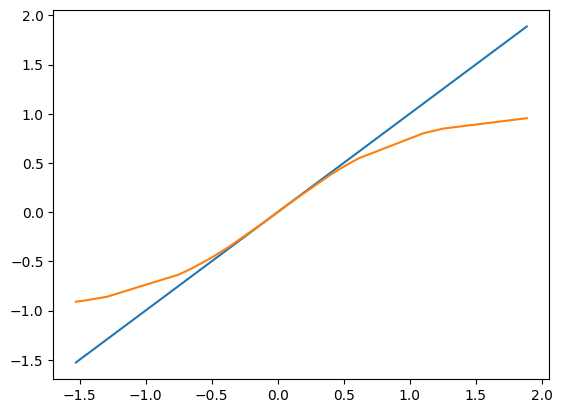

In [8]:
X = torch.randn(20).sort()[0]
print(X)
print(tanh(X))
# X = sorted(X)
plt.plot(X, X)
plt.plot(X, tanh(X))


tensor([-1.5223, -1.3503, -1.0024, -0.8869, -0.7216, -0.6995, -0.6536, -0.4907,
        -0.3490, -0.3337, -0.2595, -0.1302,  0.1233,  0.2270,  0.2994,  0.6556,
         0.6698,  0.8161,  1.0352,  2.0342])
tensor([-0.9091, -0.8741, -0.7626, -0.7099, -0.6179, -0.6041, -0.5741, -0.4548,
        -0.3355, -0.3219, -0.2539, -0.1295,  0.1227,  0.2231,  0.2907,  0.5754,
         0.5848,  0.6730,  0.7760,  0.9664])


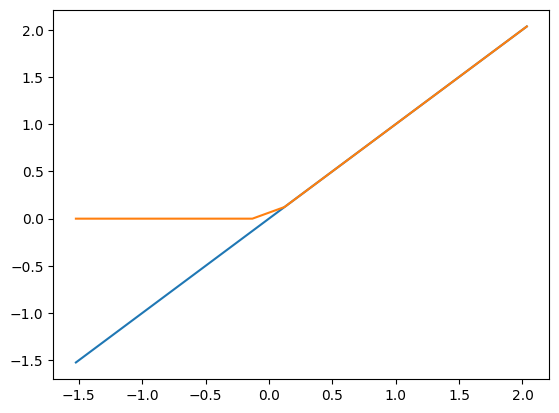

In [8]:
X = torch.randn(20).sort()[0]
print(X)
print(tanh(X))
# X = sorted(X)
plt.plot(X, X)
plt.plot(X, relu(X))


In [9]:
torch.zeros(1)


tensor([0.])

In [4]:
X = torch.randn(4, 4)
print(X)
print(flat(X))
X.numel()


tensor([[ 0.9014,  0.1880,  0.7426, -1.7965],
        [-0.9668,  1.1091, -0.6421, -0.2078],
        [-0.9781,  1.2942, -0.1494, -0.7955],
        [ 0.0565, -1.4704, -1.2808,  0.2141]])
tensor([[ 0.9014,  0.1880,  0.7426, -1.7965, -0.9668,  1.1091, -0.6421, -0.2078,
         -0.9781,  1.2942, -0.1494, -0.7955,  0.0565, -1.4704, -1.2808,  0.2141]])


16

In [19]:
X = torch.randn(4, 4)

print(batch(X))
print(batch.running_mean)
print(batch.running_var)


tensor([[-0.0577,  1.0218, -0.2243, -1.2648],
        [-1.1769, -1.2967,  1.4056, -0.1785],
        [-0.0344,  0.4816, -0.9623,  0.3175],
        [ 1.2690, -0.2067, -0.2190,  1.1259]])
tensor([[ 0.1890, -0.0969, -0.0732, -0.0087]])
tensor([[1.1317, 1.2256, 0.8649, 0.9185]])


In [3]:
torch.manual_seed(42)
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = 27


model = nn.Sequential([
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(n_embd*block_size, n_hidden,
              bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
])

print(model)


Sequence([Embedding(num_embeddings=27, embedding_dim=10), Total parameters: 270, Flatten(), Total parameters: 0, Linear(in_features=30, out_features=200, bias=False), Total parameters: 6000, Batchnorm1D(num_features=200), Total parameters: 400, Tanh(), Total parameters: 0, Linear(in_features=200, out_features=27, bias=True), Total parameters: 5427]), 
Model has total parameters: 12097


In [22]:
max_steps = 200000
batch_size = 64
lossi = []
ud = []
optim = nn.SGD(parameters, lr=0.1)

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Zero Grad and Backward pass
    optim.zero_grad()
    loss.backward()

    # Update
    optim.lr = 0.1 if i < max_steps/2 else 0.01

    # for p in parameters:
    #    p.data += -lr * p.grad
    optim.step()

    lossi.append(loss.item())
    if i % 10000 == 0:
        mloss = torch.tensor(lossi)[-10000:].mean()
        print(f'{i:7d}/{max_steps:d}: {mloss.item():4f}, {optim.lr}')

    with torch.no_grad():
        ud.append([(optim.lr*p.grad.std()/p.data.std()).log10().item()
                  for p in parameters])


200

In [3]:
words = open('../makemore_jax/names.txt', 'r').read().splitlines()
print(f'Number of names: {len(words)}')
print(
    f'Median name length: {torch.median(torch.tensor(list(len(w) for w in words))).item()}')
print(f'Max name length: {max(len(w) for w in words)}')
print(f'Example names: {words[:8]}')


Number of names: 32033
Median name length: 6
Max name length: 15
Example names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocapbulary of charactors mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
random.seed(42)
random.shuffle(words)


In [6]:
block_size = 3


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])


... ---> e
..e ---> b
.eb ---> r
ebr ---> i
bri ---> m
rim ---> a
ima ---> .
... ---> h
..h ---> i
.hi ---> l
hil ---> t
ilt ---> o
lto ---> n
ton ---> .
... ---> j
..j ---> h
.jh ---> e
jhe ---> n
hen ---> e
ene ---> .


In [31]:
torch.manual_seed(42)
n_embd = 10
n_hidden = 200

model = nn.Sequential([
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(n_embd*block_size, n_hidden,
              bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
])


parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

print(model)


Sequential(
  (0): Embedding(num_embeddings=27, embedding_dim=10), Total parameters: 270, 
  (1): Flatten(), Total parameters: 0, 
  (2): Linear(in_features=30, out_features=200, bias=False), Total parameters: 6000, 
  (3): Batchnorm1D(num_features=200), Total parameters: 400, 
  (4): Tanh(), Total parameters: 0, 
  (5): Linear(in_features=200, out_features=27, bias=True), Total parameters: 5427, 
)
Total parameters: 12097


In [32]:
max_steps = 200000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Zero Grad
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:d}: {loss.item():4f}')

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item()
                  for p in parameters])


      0/200000: 3.761614
  10000/200000: 2.476745
  20000/200000: 2.090284
  30000/200000: 2.124772
  40000/200000: 2.076088
  50000/200000: 2.321423
  60000/200000: 1.917560
  70000/200000: 2.108340
  80000/200000: 2.126670
  90000/200000: 2.019176
 100000/200000: 2.400859
 110000/200000: 2.194901
 120000/200000: 2.137100
 130000/200000: 1.933233
 140000/200000: 1.935771
 150000/200000: 1.752927
 160000/200000: 2.039273
 170000/200000: 2.233839
 180000/200000: 2.039437
 190000/200000: 1.738539


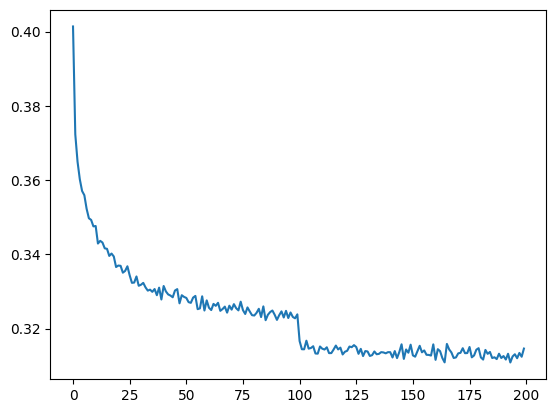

In [33]:
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1, keepdim=True))


In [8]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


for layer in model.layers:
    layer.training = False
split_loss('train')
split_loss('val')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (182580x30 and 1x128)

In [35]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


skimberlynn.
carenceliya.
jacoutneli.
zeliomah.
uad.
muctan.
mae.
sukatherdo.
bri.
kosaia.
dami.
emmeriston.
mery.
raki.
khish.
clani.
jaylin.
haz.
giovanna.
flack.


In [9]:
torch.manual_seed(42)
n_embd = 10
n_hidden = 200

model = nn.Sequential([
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(n_embd*block_size, n_hidden,
              bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
])


parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

print(model)


Sequential(
  (0): Embedding(num_embeddings=27, embedding_dim=10), Total parameters: 270, 
  (1): Flatten(), Total parameters: 0, 
  (2): Linear(in_features=30, out_features=200, bias=False), Total parameters: 6000, 
  (3): Batchnorm1D(num_features=200), Total parameters: 400, 
  (4): Tanh(), Total parameters: 0, 
  (5): Linear(in_features=200, out_features=27, bias=True), Total parameters: 5427, 
)
Total parameters: 12097


In [10]:
max_steps = 200000
batch_size = 64
lossi = []
ud = []
optim = nn.SGD(parameters, lr=0.1)

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Zero Grad and Backward pass
    optim.zero_grad()
    loss.backward()

    # Update
    optim.lr = 0.1 if i < max_steps/2 else 0.01

    # for p in parameters:
    #    p.data += -lr * p.grad
    optim.step()

    lossi.append(loss.item())
    if i % 10000 == 0:
        mloss = torch.tensor(lossi)[-10000:].mean()
        print(f'{i:7d}/{max_steps:d}: {mloss.item():4f}, {optim.lr}')

    with torch.no_grad():
        ud.append([(optim.lr*p.grad.std()/p.data.std()).log10().item()
                  for p in parameters])


      0/200000: 3.747302, 0.1
  10000/200000: 2.305099, 0.1
  20000/200000: 2.202176, 0.1
  30000/200000: 2.168681, 0.1
  40000/200000: 2.149550, 0.1
  50000/200000: 2.139941, 0.1
  60000/200000: 2.126383, 0.1
  70000/200000: 2.124258, 0.1
  80000/200000: 2.118143, 0.1
  90000/200000: 2.117481, 0.1
 100000/200000: 2.114033, 0.01
 110000/200000: 2.072109, 0.01
 120000/200000: 2.067954, 0.01
 130000/200000: 2.066607, 0.01
 140000/200000: 2.069798, 0.01
 150000/200000: 2.067392, 0.01
 160000/200000: 2.066038, 0.01
 170000/200000: 2.064824, 0.01
 180000/200000: 2.064353, 0.01
 190000/200000: 2.065345, 0.01


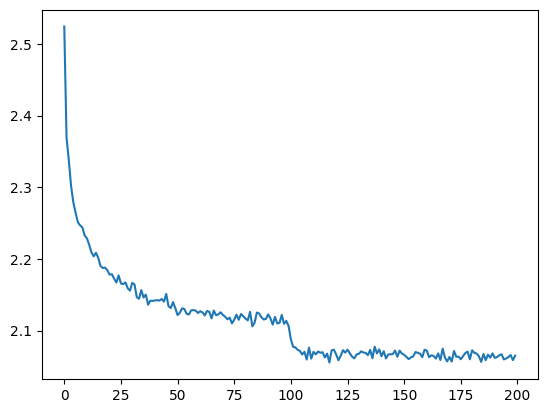

In [19]:
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1, keepdim=True))


In [20]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


for layer in model.layers:
    layer.training = False
split_loss('train')
split_loss('val')


train 2.044288158416748
val 2.097588539123535


In [20]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


TypeError: 'MyModel' object is not callable

In [11]:
aa = nn.Optimizer(parameters, lr=0.2)


In [12]:
aa.zero_grad()


In [13]:
aa


In [17]:
?nn.Optimizer


Init signature: nn.Optimizer(params, lr=0.01)
Docstring:      <no docstring>
Init docstring: Minibatch stochastic gradient descent.
File:           ~/Documents/AI/scratch/mytorch/mytorch/nn.py
Type:           type
Subclasses:     SGD